<center>
    <h1> Redes Neuronales Bayesianas </h2>
</center>

## Contenidos

* [Introducción](#Introducción)
* [Bibliotecas](#Bibliotecas)
* [Datos](#Datos)
* [Red Neuronal Tradicional](#Red-Neuronal-Tradicional)
* [Red Neuronal Bayesiana con Inferencia Bayesiana](#Red-Neuronal-Bayesiana-con-Inferencia-Bayesiana)
* [Red Neuronal Bayesiana con Dropout](#Red-Neuronal-Bayesiana-con-Dropout)
* [Comparación de resultados](#Comparación-de-resultados)

## Introducción

En el siguiente notebook, se ejemplifica como resolver una tarea de regresión utilizando una Red Neuronal "estándar" y dos Redes Neuronales Bayesianas basadas en distintas técnicas: Inferencia Bayesiana y Dropout.

Ejemplo obtenido de https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb

## Bibliotecas

La biblioteca ``tensorflow_probability`` requiere versiones específicas de TensorFlow y Keras para funcionar correctamente. Se recomienda instalar las siguientes versiones según las notas de lanzamiento oficiales:

1. TensorFlow 2.15.0
2. Keras 2.15.0
3. TensorFlow Probability 0.23.0v

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import urllib.request
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout

In [3]:
tfd = tfp.distributions
tfb = tfp.bijectors

## Datos

Utilizaremos un conjunto de datos simulados a partir de una onda sinusoidal que tiene una pequeña tendencia lineal positiva y una varianza que depende de la amplitud.

In [4]:
def create_sine_data(n=2048):
    np.random.seed(32)
    x = np.linspace(0, 1 * 2 * np.pi, n)
    y1 = 3 * np.sin(x)
    y1 = np.concatenate(
        (np.zeros(60), y1 + np.random.normal(0, 0.15 * np.abs(y1), n), np.zeros(60))
    )
    x = np.concatenate(
        (
            np.linspace(-3, 0, 60),
            np.linspace(0, 3 * 2 * np.pi, n),
            np.linspace(3 * 2 * np.pi, 3 * 2 * np.pi + 3, 60),
        )
    )
    y2 = 0.1 * x + 1
    y = y1 + y2
    return x, y

In [5]:
x, y = create_sine_data(256)
n = len(x)
n

376

Text(0, 0.5, 'y')

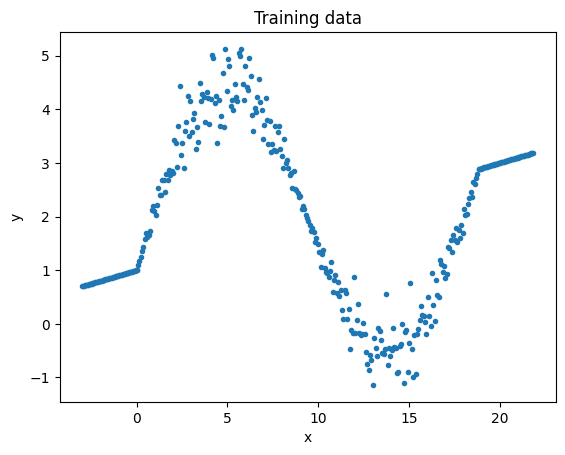

In [6]:
plt.scatter(x=x, y=y, marker='.',alpha=1)
plt.title("Training data")
plt.xlabel("x")
plt.ylabel("y")

## Utilidades

In [7]:
x_pred = np.arange(-10, 30, 0.3)
TRAIN = False
EPOCHS = 1000
BATCH_SIZE = 32
NUM_RUNS = 200
NUM_PREDICTIONS = len(x_pred)

In [8]:
def negative_log_likelihood(y_true, distribution):
    return -distribution.log_prob(y_true)

def create_normal_distribution(params):
    loc = params[:, 0:1]
    scale = 1e-3 + tf.math.softplus(0.05 * params[:, 1:2])
    return tfp.distributions.Normal(loc=loc, scale=scale)

def create_normal_exp(params):
    loc = params[:, 0:1]
    scale = 1e-3 + tf.math.softplus(0.05 * params[:, 1:2])
    return tfp.distributions.Normal(loc=loc, scale=scale)

def plot_predictions(
    x,
    y,
    x_pred,
    preds,
    alpha_data=1,
    ylim=[-7, 8],
    xlabel="x",
    ylabel="y",
    title="",
    plot_mean_quantiles=False,
):

    plt.scatter(x, y, color="steelblue", alpha=alpha_data, marker=".")

    for pred in preds:
        plt.plot(x_pred, pred, color="orange", linewidth=0.2, alpha=0.4)

    if plot_mean_quantiles:
        mean_preds = np.mean(preds, axis=0)
        lower_quantile = np.quantile(preds, 0.025, axis=0)
        upper_quantile = np.quantile(preds, 0.975, axis=0)

        plt.plot(x_pred, mean_preds, color="black", linewidth=1.5, label="Mean")
        plt.plot(x_pred, lower_quantile, color="red", linewidth=1.5, linestyle="--", label="2.5% Quantile")
        plt.plot(x_pred, upper_quantile, color="red", linewidth=1.5, linestyle="--", label="97.5% Quantile")
        plt.legend()

    plt.ylim(ylim)
    plt.xlabel(xlabel, size=16)
    plt.ylabel(ylabel, size=16)
    plt.title(title, size=18)

    plt.show()


## Red Neuronal Tradicional

El primer modelo es una red que aprende los parámetros $\mu_x$ y $\sigma_x$ de una distribución normal a partir de los datos de entrenamiento.

La incertidumbre se modela en las predicciones utilizando una capa de distribución al final.

In [9]:
inputs = Input(shape=(1,), name="input_layer")
hidden_layer_1 = Dense(20, activation="relu", name="hidden_layer_1")(inputs)
hidden_layer_2 = Dense(50, activation="relu", name="hidden_layer_2")(hidden_layer_1)
hidden_layer_3 = Dense(20, activation="relu", name="hidden_layer_3")(hidden_layer_2)
params_output = Dense(2)(hidden_layer_3)
distribution_output = tfp.layers.DistributionLambda(create_normal_distribution)(
    params_output
)

model_1 = Model(inputs=inputs, outputs=distribution_output)
model_1.compile(optimizer=Adam(), loss=negative_log_likelihood)

# model_1.summary()

In [10]:
if TRAIN:
    history = model_1.fit(x, y, epochs=EPOCHS, batch_size=BATCH_SIZE)

    plt.plot(history.history["loss"])
    plt.legend(["loss"])
    plt.ylabel("NLL")
    plt.xlabel("Epochs")
    plt.show()
else:
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_weights.hdf5",
        "model_nobay.hdf5",
    )
    model_1 = model_1.load_weights("model_nobay.hdf5")
    model_1 = Model(inputs=inputs, outputs=distribution_output)

In [11]:
predictions_1 = np.zeros((NUM_RUNS, NUM_PREDICTIONS))

for index in range(NUM_RUNS):
    prediction = model_1.predict(x_pred).reshape(NUM_PREDICTIONS)
    predictions_1[index, :] = prediction

5/5 [==============================] - 0s 730us/step


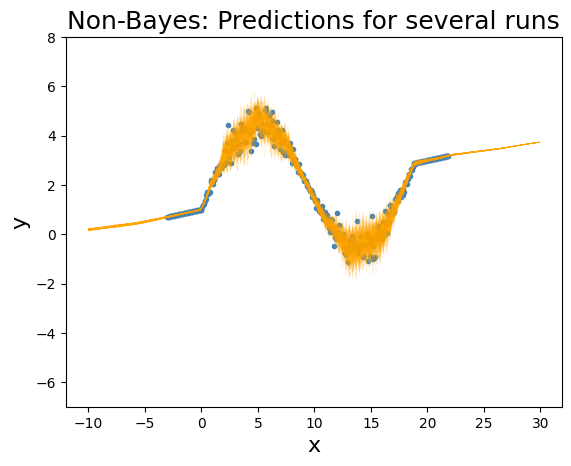

In [12]:
plot_predictions(x, y, x_pred, predictions_1, title="Non-Bayes: Predictions for several runs")

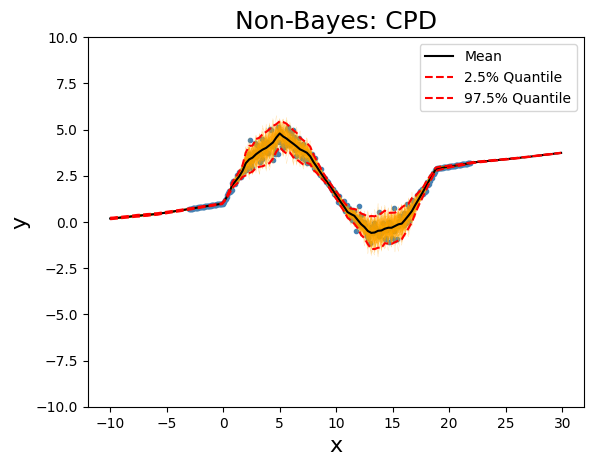

In [13]:
plot_predictions(x, y, x_pred, predictions_1, ylim=[-10,10], title='Non-Bayes: CPD', plot_mean_quantiles=True)

##  Red Neuronal con Inferencia Variacional

El segundo modelo es una red Bayesiana que utiliza Inferencia Variacional para aprender los parámetros de la distribución posterior de los pesos y biases de la red.

La incertidumbre se modela en los parámetros de la red (pesos y biases) usando técnicas bayesianas ([DenseFlipout](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout)).

In [14]:
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (
    x.shape[0] * 1.0
)
bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (
    x.shape[0] * 1.0
)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(
    20,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
    activation="relu",
)(inputs)
hidden = tfp.layers.DenseFlipout(
    50,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
    activation="relu",
)(hidden)
hidden = tfp.layers.DenseFlipout(
    20,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
    activation="relu",
)(hidden)
params = tfp.layers.DenseFlipout(
    2,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
)(hidden)
distribution_output = tfp.layers.DistributionLambda(create_normal_distribution)(params)


model_2 = Model(inputs=inputs, outputs=distribution_output)
model_2.compile(Adam(learning_rate=0.0002), loss=negative_log_likelihood)

# model_vi.summary()

/Users/diego/dev/INF-473-IntroXAI/.venv/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/diego/dev/INF-473-IntroXAI/.venv/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [15]:
if TRAIN:
    history = model_2.fit(x, y, epochs=EPOCHS, batch_size=BATCH_SIZE)

    plt.plot(history.history["loss"])
    plt.legend(["loss"])
    plt.ylabel("NLL")
    plt.xlabel("Epochs")
    plt.show()

else:
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi.hdf5",
        "model_vi.hdf5",
    )
    model_2.load_weights("model_vi.hdf5")
    model_2 = Model(inputs=inputs, outputs=distribution_output)

In [16]:
predictions_2 = np.zeros((NUM_RUNS, NUM_PREDICTIONS))
for index in range(NUM_RUNS):
    prediction = model_2.predict(x_pred).reshape(NUM_PREDICTIONS)
    predictions_2[index, :] = prediction

5/5 [==============================] - 0s 954us/step


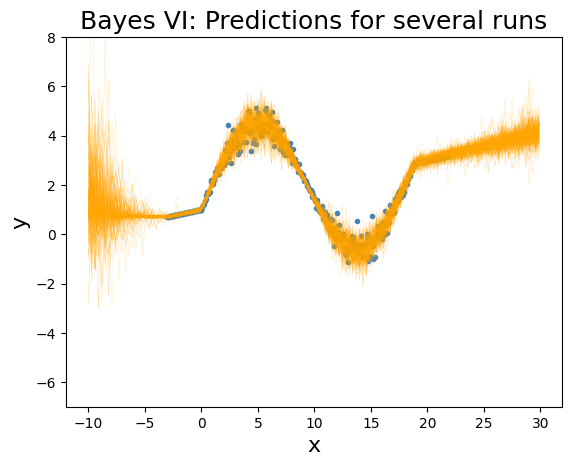

In [17]:
plot_predictions(x, y, x_pred, predictions_2, title="Bayes VI: Predictions for several runs")

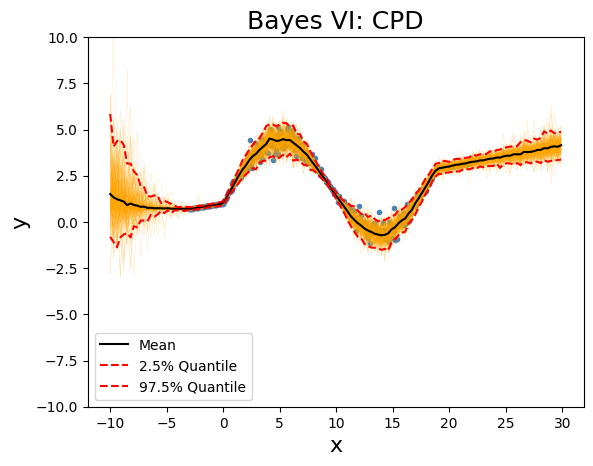

In [18]:
plot_predictions(x, y, x_pred, predictions_2, ylim=[-10,10], title='Bayes VI: CPD', plot_mean_quantiles=True)

## Red Neuronal Bayesiana con Dropout

El tercer modelo es una red Bayesiana que utiliza Dropout para modelar la incertidumbre en las predicciones.

La incertidumbre se modela en las predicciones utilizando Monte Carlo Dropout para simular un ensamble de redes neuronales.

In [19]:
inputs = Input(shape=(1,))
hidden = Dense(200, activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500, activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500, activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500, activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200, activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(create_normal_exp, name="normal_exp")(params_mc)

model_3 = Model(inputs=inputs, outputs=dist_mc)
model_3.compile(Adam(learning_rate=0.0002), loss=negative_log_likelihood)

# model_mc.summary()

In [20]:
if TRAIN:
    history = model_3.fit(x, y, epochs=EPOCHS, batch_size=BATCH_SIZE)

    plt.plot(history.history["loss"])
    plt.legend(["loss"])
    plt.ylabel("NLL")
    plt.xlabel("Epochs")
    plt.show()
else:
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc.hdf5",
        "model_mc.hdf5",
    )
    model_3.load_weights("model_mc.hdf5")
    model_3 = Model(inputs=inputs, outputs=dist_mc)

In [21]:
predictions_3 = np.zeros((NUM_RUNS, NUM_PREDICTIONS))
for index in range(NUM_RUNS):
    prediction = model_3.predict(x_pred).reshape(NUM_PREDICTIONS)
    predictions_3[index, :] = prediction

5/5 [==============================] - 0s 2ms/step


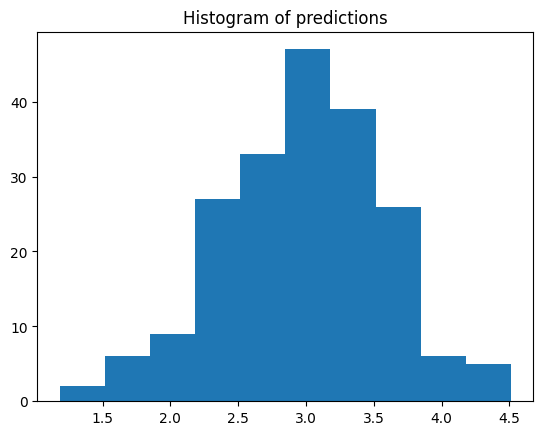

In [22]:
plt.hist(predictions_3[:,100])
plt.title('Histogram of predictions')
plt.show()

## Comparación de resultados

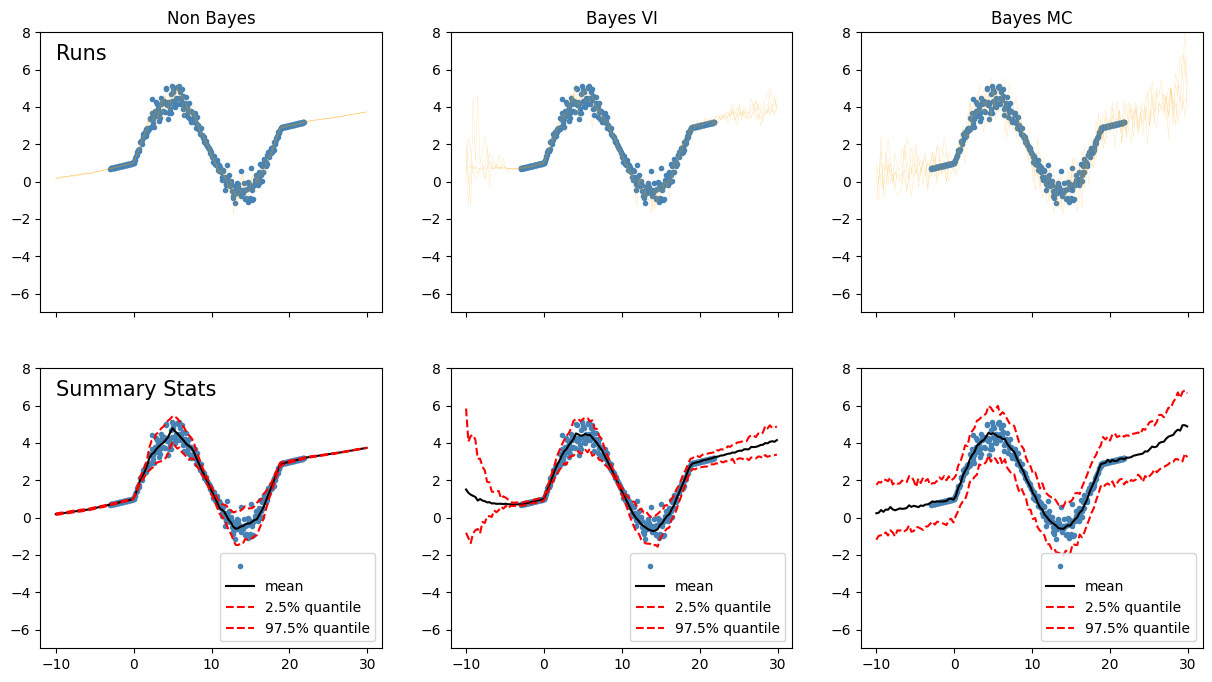

In [23]:
def make_plot_runs(ax, preds, x, y, x_pred, alpha_data=1, ylim=[-7, 8]):
    ax.scatter(x, y, color="steelblue", alpha=alpha_data, marker=".")
    for i in range(preds.shape[0]):
        ax.plot(x_pred, preds[i], color="orange", linewidth=0.2, alpha=0.4)
    ax.set_ylim(ylim)

def make_plot_runs_avg(ax, preds, x, y, x_pred, alpha_data=1, ylim=[-7, 8]):
    ax.scatter(x, y, color="steelblue", alpha=alpha_data, marker=".")
    ax.plot(x_pred, np.mean(preds, axis=0), color="black", linewidth=1.5)
    ax.plot(x_pred, np.quantile(preds, 0.025, axis=0), color="red", linewidth=1.5, linestyle="--")
    ax.plot(x_pred, np.quantile(preds, 0.975, axis=0), color="red", linewidth=1.5, linestyle="--")
    ax.set_ylim(ylim)

# Assuming predictions_1, predictions_2, predictions_3, x, y, and x_pred are already defined
f, ax = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(15, 8))

lines = 5

# Non Bayes
ax[0,0].set_title('Non Bayes')
make_plot_runs(ax[0,0], predictions_1[:lines], x, y, x_pred)
make_plot_runs_avg(ax[1,0], predictions_1, x, y, x_pred)
ax[1,0].legend(('','mean','2.5% quantile','97.5% quantile'), loc='lower right')

# Bayes VI
ax[0,1].set_title('Bayes VI')
make_plot_runs(ax[0,1], predictions_2[:lines], x, y, x_pred, ylim=[-7,8])
make_plot_runs_avg(ax[1,1], predictions_2, x, y, x_pred, ylim=[-7,8])
ax[1,1].legend(('','mean','2.5% quantile','97.5% quantile'), loc='lower right')

# Bayes MC
ax[0,2].set_title('Bayes MC')
make_plot_runs(ax[0,2], predictions_3[:lines], x, y, x_pred, ylim=[-7,8])
make_plot_runs_avg(ax[1,2], predictions_3, x, y, x_pred, ylim=[-7,8])
ax[1,2].legend(('','mean','2.5% quantile','97.5% quantile'), loc='lower right')

# Adding text labels
ax[0,0].text(-10, 6.5, "Runs", fontsize=15, horizontalalignment='left')
ax[1,0].text(-10, 6.5, "Summary Stats", fontsize=15, horizontalalignment='left')

plt.show()
